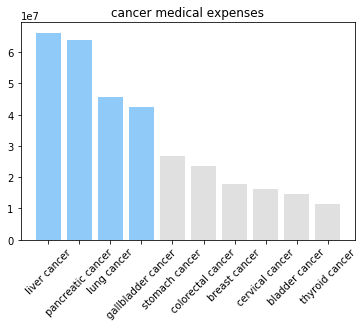

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(10)
cencer = ['liver cancer', 'pancreatic cancer', 'lung cancer', 'gallbladder cancer', 'stomach cancer', 'colorectal cancer', 'breast cancer', 'cervical cancer','bladder cancer', 'thyroid cancer']
cost = [66227000, 63717000, 45673000, 42540000, 26856000, 23520000, 17685000, 16126000, 14641000, 11263000]
plt.bar(x, cost)
plt.title('cancer medical expenses')
plt.xticks(x, cencer, rotation=45)

In [ ]:
!pip install eli5
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
df = pd.read_csv("survey lung cancer.csv")
df.head().T

,0,1,2,3,4
GENDER,M,M,F,M,F
AGE,69,74,59,63,63
SMOKING,1,2,1,2,1
YELLOW_FINGERS,2,1,1,2,2
ANXIETY,2,1,1,2,1
PEER_PRESSURE,1,1,2,1,1
CHRONIC DISEASE,1,2,1,1,1
FATIGUE,2,2,2,1,1
ALLERGY,1,2,1,1,1
WHEEZING,2,1,2,1,2


In [ ]:
df = df.drop_duplicates().reset_index(drop=True)
df.head().T

,0,1,2,3,4
GENDER,M,M,F,M,F
AGE,69,74,59,63,63
SMOKING,1,2,1,2,1
YELLOW_FINGERS,2,1,1,2,2
ANXIETY,2,1,1,2,1
PEER_PRESSURE,1,1,2,1,1
CHRONIC DISEASE,1,2,1,1,1
FATIGUE,2,2,2,1,1
ALLERGY,1,2,1,1,1
WHEEZING,2,1,2,1,2


<BarContainer object of 39 artists>

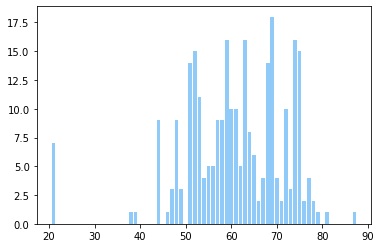

In [ ]:
plt.bar(df["AGE"].unique(), df["AGE"].value_counts())

In [ ]:
for col in df.columns[2:-1]:
    df.loc[(df[col] == 1), col] = 0
    df.loc[(df[col] == 2), col] = 1
df.loc[(df["GENDER"] == "M"), "GENDER"] = 0
df.loc[(df["GENDER"] == "F"), "GENDER"] = 1
df["GENDER"] = df["GENDER"].astype("int64")
df.loc[(df["LUNG_CANCER"] == "NO"), "LUNG_CANCER"] = 0
df.loc[(df["LUNG_CANCER"] == "YES"), "LUNG_CANCER"] = 1
df["LUNG_CANCER"] = df["LUNG_CANCER"].astype("int64")
age_group = []
for i in df["AGE"]:
    if i < 40:
        age_group.append(0) # YOUTH
    elif i < 60:
        age_group.append(1) # MIDDLE
    else:
        age_group.append(2) # OLD
df.insert(2, "AGE_GROUP", age_group)
df.head().T

,0,1,2,3,4
GENDER,0,0,1,0,1
AGE,69,74,59,63,63
AGE_GROUP,2,2,1,2,2
SMOKING,0,1,0,1,0
YELLOW_FINGERS,1,0,0,1,1
ANXIETY,1,0,0,1,0
PEER_PRESSURE,0,0,1,0,0
CHRONIC DISEASE,0,1,0,0,0
FATIGUE,1,1,1,0,0
ALLERGY,0,1,0,0,0


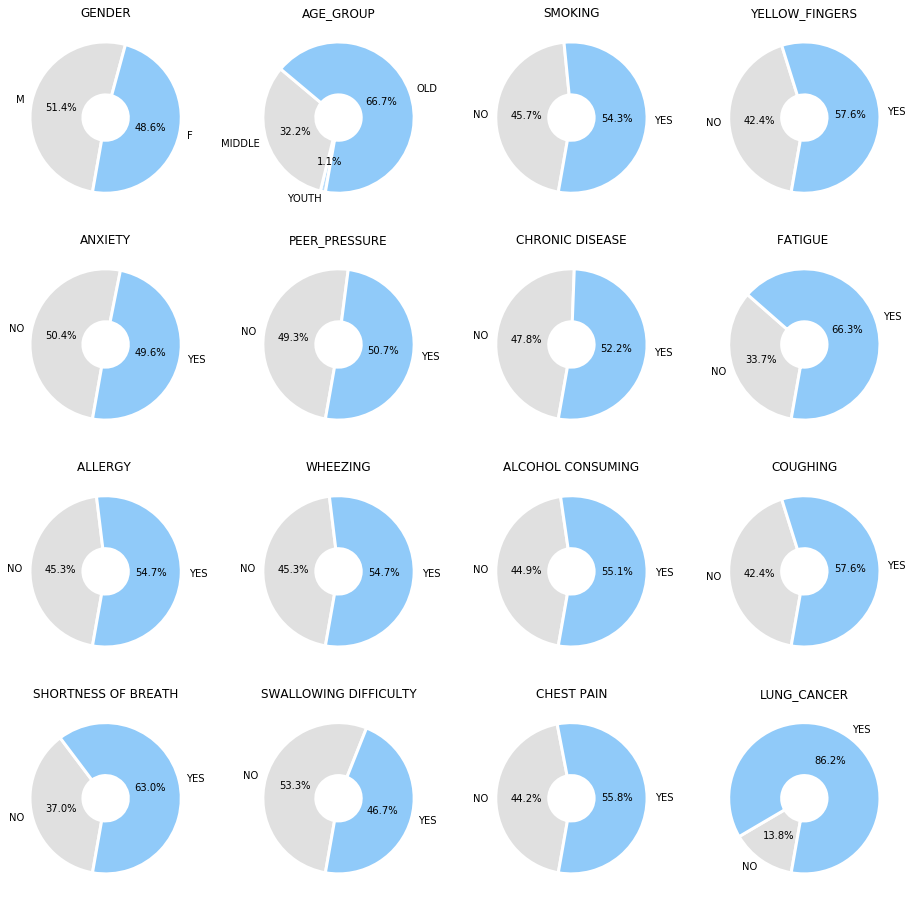

In [ ]:
columns = list(df.columns)
columns.remove("AGE")
plt.figure(figsize=(16, 16))
for i, col in enumerate(columns):
    ratio = list(df[col].value_counts().sort_index() / len(df))
    labels = ["NO", "YES"]
    if col == "GENDER":
        labels = ["M", "F"]
    if col == "AGE_GROUP":
        labels = ["YOUTH", "MIDDLE", "OLD"]
    plt.subplot(4, 4, i+1)
    plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False)
    plt.title(col)

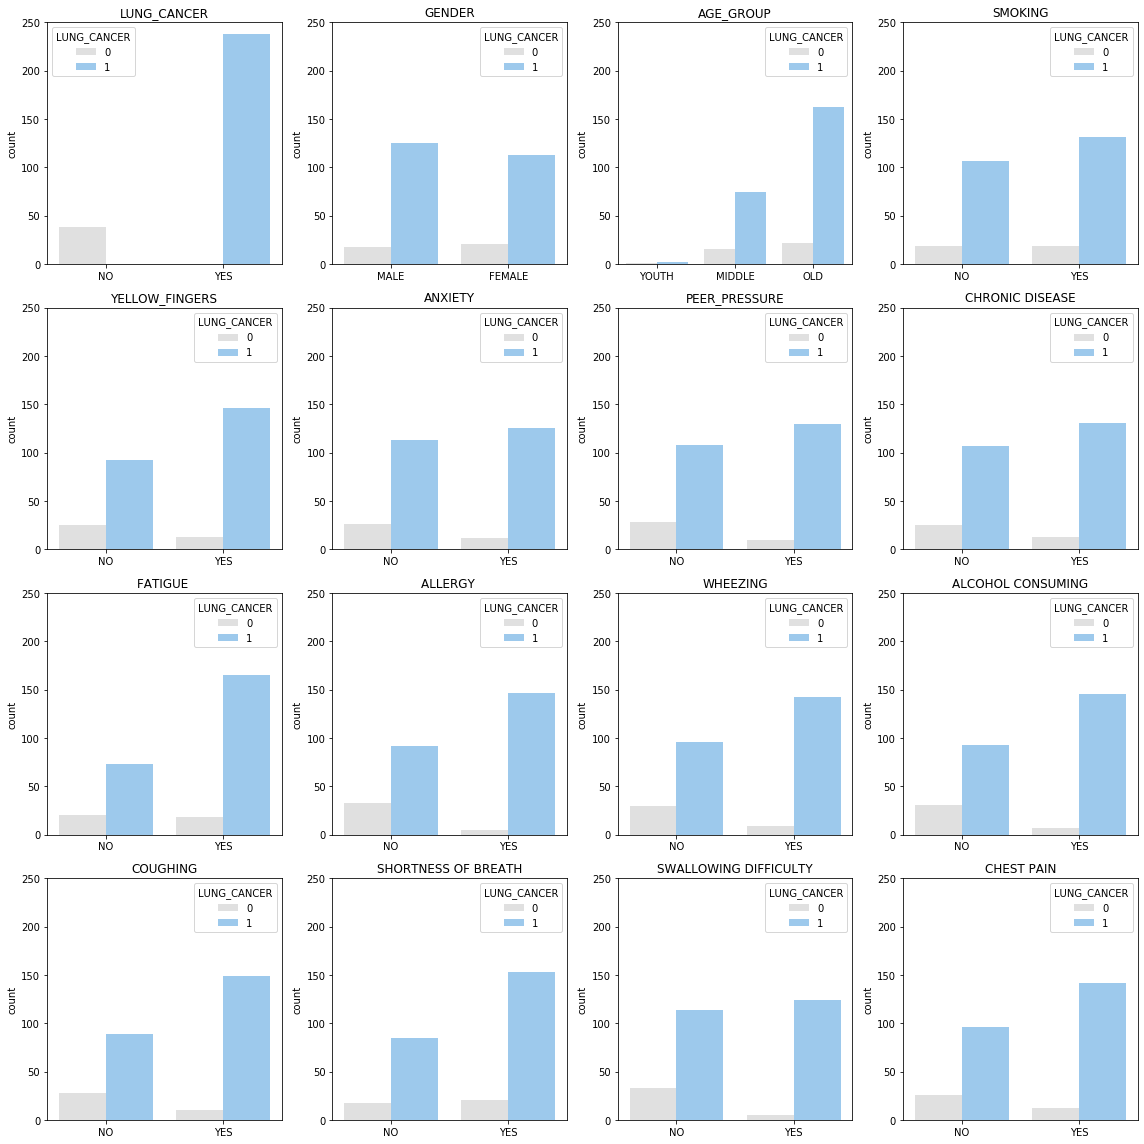

In [ ]:
columns = list(df.columns)
columns.remove("AGE")
plt.figure(figsize=(16, 16))
for i, col in enumerate(columns):
    if col == "LUNG_CANCER":
        plt.subplot(4, 4, 1)
    else:
        plt.subplot(4, 4, i+2)
    p = sns.countplot(col, hue="LUNG_CANCER", data=df)
    plt.title(col)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5]),
 <a list of 17 Text xticklabel objects>)

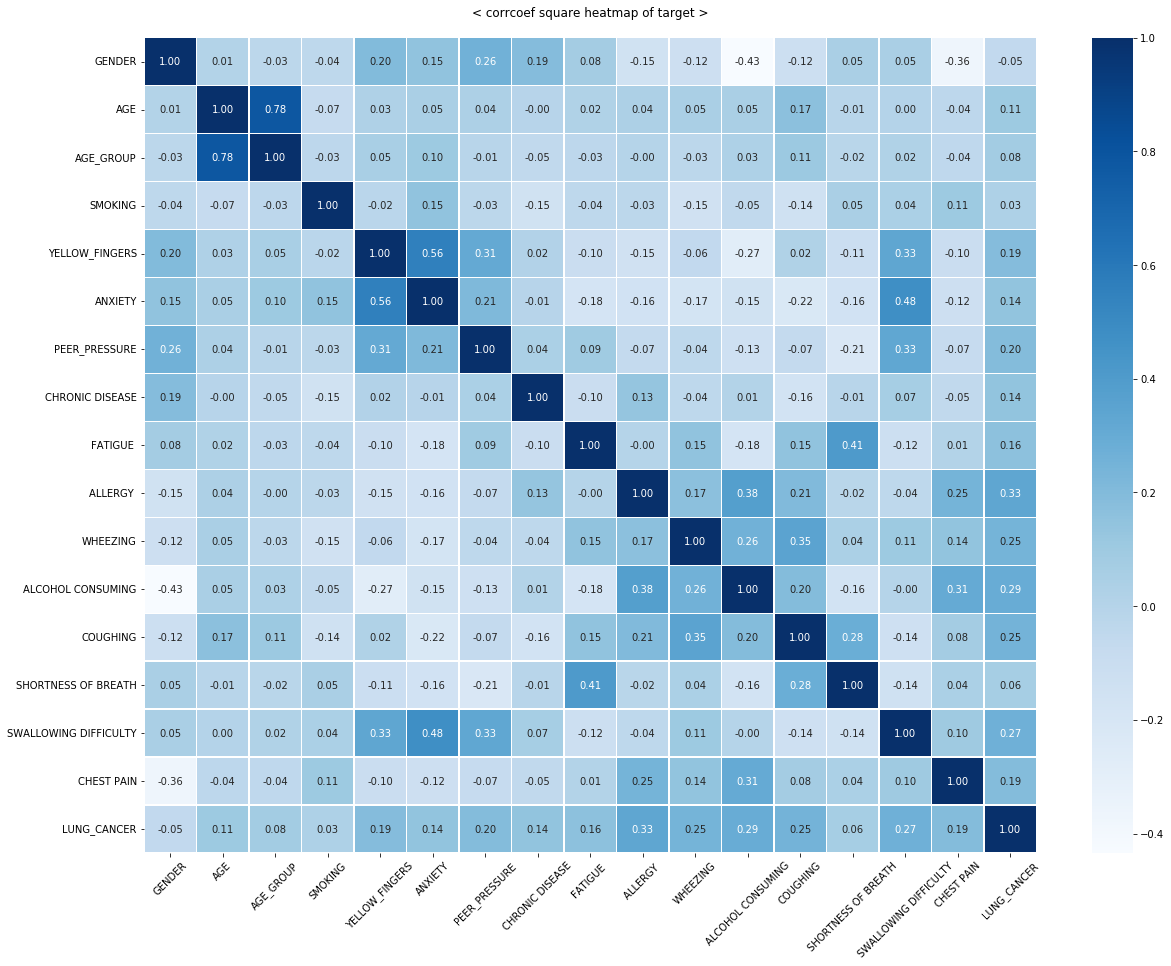

In [ ]:
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(20,15))
ax = sns.heatmap(data = df.corr(), annot=True, fmt = '.2f', linewidths=.5)
plt.title('< corrcoef square heatmap of target >\n')
plt.xticks(rotation=45)

In [ ]:
major = df["LUNG_CANCER"].mode()[0]
baseline = np.array([major] * len(df))
y_true = df["LUNG_CANCER"]
baseline_accuracy = (np.array(y_true) == np.array(baseline)).sum() / len(df)
print("baseline accuracy:", baseline_accuracy)

baseline accuracy: 0.8623188405797102


In [ ]:
target = "LUNG_CANCER"
X, y = df.drop(target, axis=1), df[target]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

In [ ]:
params = {'n_estimators' : [100, 300, 500], 'learning_rate' : [0.01, 0.005, 0.001], 'max_depth' : [3, 7, 10]}
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, scoring='recall', n_jobs=-1, cv=3, verbose=3, random_state=2)
clf.fit(X_train, y_train)
print("최적 학습 파라미터:", clf.best_params_) 
print("학습 데이터 재현율:", round(clf.best_score_, 3))
model = clf.best_estimator_
y_pred = model.predict(X_valid)
recall1 = round(recall_score(y_pred, y_valid), 3)
print("검증 데이터 재현율:", recall1)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
최적 학습 파라미터: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.005}
학습 데이터 재현율: 0.958
검증 데이터 재현율: 0.891


In [ ]:
permuter = PermutationImportance(model,scoring="recall", n_iter=5,random_state=1)
X_valid_transformed = X_valid
permuter.fit(X_valid_transformed, y_valid)

In [ ]:
feature_names = X_valid.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

YELLOW_FINGERS           0.064
ALCOHOL CONSUMING        0.060
CHRONIC DISEASE          0.004
GENDER                   0.000
AGE                      0.000
AGE_GROUP                0.000
SMOKING                  0.000
ANXIETY                  0.000
PEER_PRESSURE            0.000
FATIGUE                  0.000
ALLERGY                  0.000
WHEEZING                 0.000
COUGHING                 0.000
SHORTNESS OF BREATH      0.000
SWALLOWING DIFFICULTY    0.000
CHEST PAIN               0.000
dtype: float64

In [ ]:
eli5.show_weights(permuter,top=None,feature_names=feature_names)

Weight,Feature
0.0640 ± 0.0160,YELLOW_FINGERS
0.0600 ± 0.0358,ALCOHOL CONSUMING
0.0040 ± 0.0299,CHRONIC DISEASE
0 ± 0.0000,CHEST PAIN
0 ± 0.0000,SWALLOWING DIFFICULTY
0 ± 0.0000,SHORTNESS OF BREATH
0 ± 0.0000,COUGHING
0 ± 0.0000,WHEEZING
0 ± 0.0000,ALLERGY
0 ± 0.0000,FATIGUE


(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f515ac5a310>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f515ac8a550>})

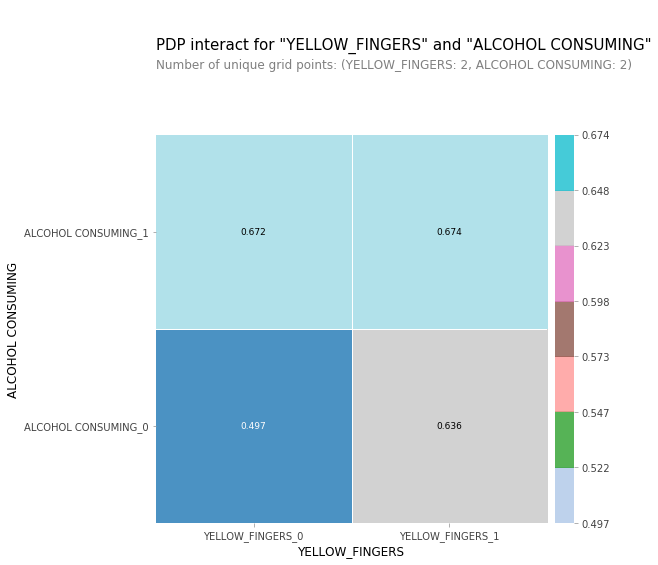

In [ ]:
features = ["YELLOW_FINGERS", "ALCOHOL CONSUMING"]
interaction = pdp_interact(model=model, dataset=X_valid, model_features=X_valid.columns,  features=features)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

In [ ]:
importance = model.feature_importances_
feature = X_train.columns
importances = pd.DataFrame()
importances['feature'] = feature
importances['importances'] = importance
importances.sort_values('importances', ascending=False, inplace=True)
importances.reset_index(drop=True, inplace=True)
importances

,feature,importances
0,YELLOW_FINGERS,0.250424
1,ALCOHOL CONSUMING,0.150527
2,SWALLOWING DIFFICULTY,0.134262
3,FATIGUE,0.133061
4,ALLERGY,0.122581
5,COUGHING,0.080569
6,CHRONIC DISEASE,0.052011
7,WHEEZING,0.048581
8,PEER_PRESSURE,0.015624
9,AGE,0.012361


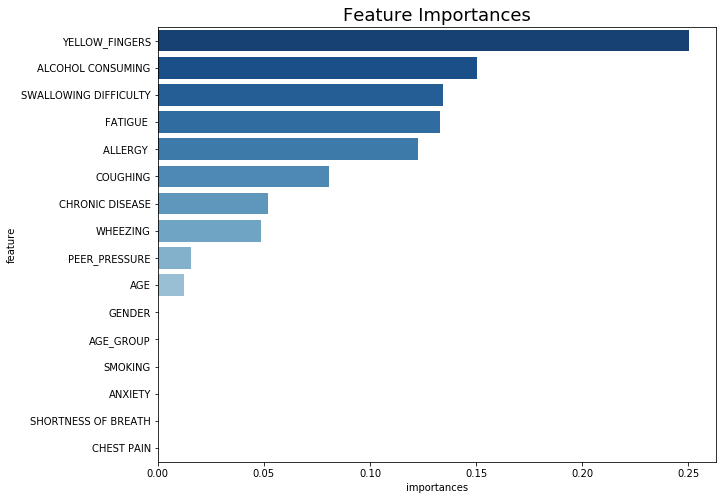

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x="importances", y="feature", data=importances)
plt.title("Feature Importances", fontsize=18)

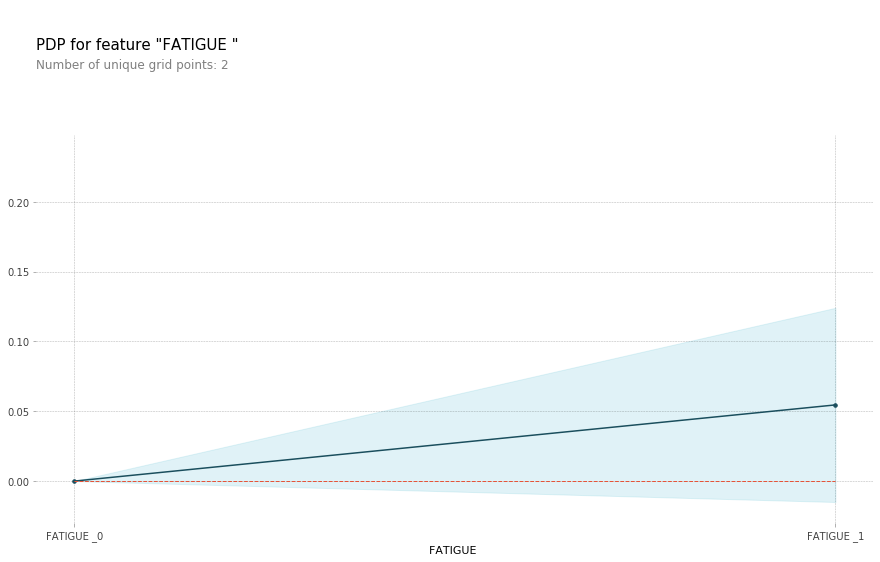

In [ ]:
feature = "FATIGUE "
isolated = pdp_isolate(model=model, dataset=X_valid, model_features=X_valid.columns, feature=feature,grid_type='percentile', # default='percentile', or 'equal'num_grid_points=10) # default=10
pdp_plot(isolated, feature_name=feature)

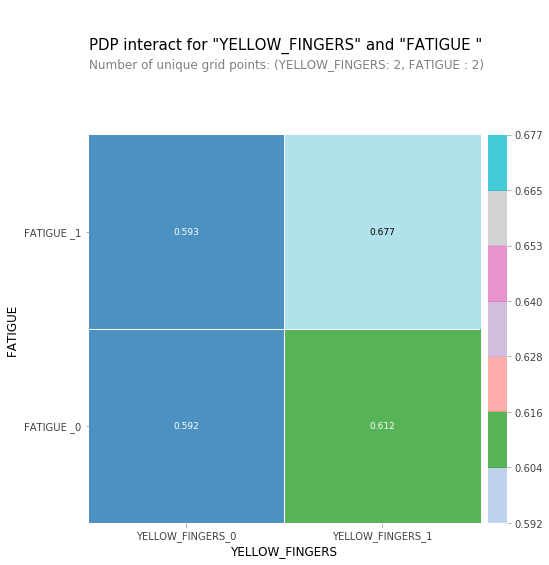

In [ ]:
features = ["YELLOW_FINGERS", "FATIGUE "]
interaction = pdp_interact(model=model, dataset=X_valid, model_features=X_valid.columns, features=features)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

In [ ]:
minimum_importance = 0.001
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_valid_selected = X_valid[features]
print('특성 삭제 전:', X_train.shape, X_valid.shape)
print('특성 삭제 후:', X_train_selected.shape, X_valid_selected.shape)

특성 삭제 전: (220, 16) (56, 16)
특성 삭제 후: (220, 3) (56, 3)


In [ ]:
params = {'n_estimators' : [100, 300, 500], 'learning_rate' : [0.005, 0.001, 0.0005], 'max_depth' : [3, 7, 10]}
xgb = XGBClassifier()
clf3 = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, scoring='recall', n_jobs=-1, cv=3, verbose=3, random_state=2)
clf3.fit(X_train_selected, y_train)
print("최적 학습 파라미터:", clf3.best_params_) 
print("학습 데이터 재현율:", round(clf3.best_score_, 3))
model3 = clf3.best_estimator_
y_pred3 = model3.predict(X_valid_selected)
recall3 = round(recall_score(y_pred3, y_valid), 3)
print("검증 데이터 재현율:", recall3)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
최적 학습 파라미터: {'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.0005}
학습 데이터 재현율: 0.989
검증 데이터 재현율: 0.891


In [ ]:
drop_feature = importances[importances['importances']==0]['feature']
X_train2 = X_train.drop(drop_feature, axis=1)
X_valid2 = X_valid.drop(drop_feature, axis=1)
params = { 'n_estimators' : [100, 300, 500], 'learning_rate' : [0.01, 0.005, 0.001], 'max_depth' : [3, 7, 10]}
xgb = XGBClassifier()
clf2 = RandomizedSearchCV(xgb, param_distributions=params, n_iter=5, scoring='recall', n_jobs=-1, cv=3, verbose=3, random_state=2)
clf2.fit(X_train2, y_train)
print("최적 학습 파라미터:", clf2.best_params_) 
print("학습 데이터 재현율:", round(clf2.best_score_, 3))
model2 = clf2.best_estimator_
y_pred2 = model2.predict(X_valid2)
recall2 = round(recall_score(y_pred2, y_valid), 3)
print("검증 데이터 재현율:", recall2)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
최적 학습 파라미터: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}
학습 데이터 재현율: 0.952
검증 데이터 재현율: 0.923


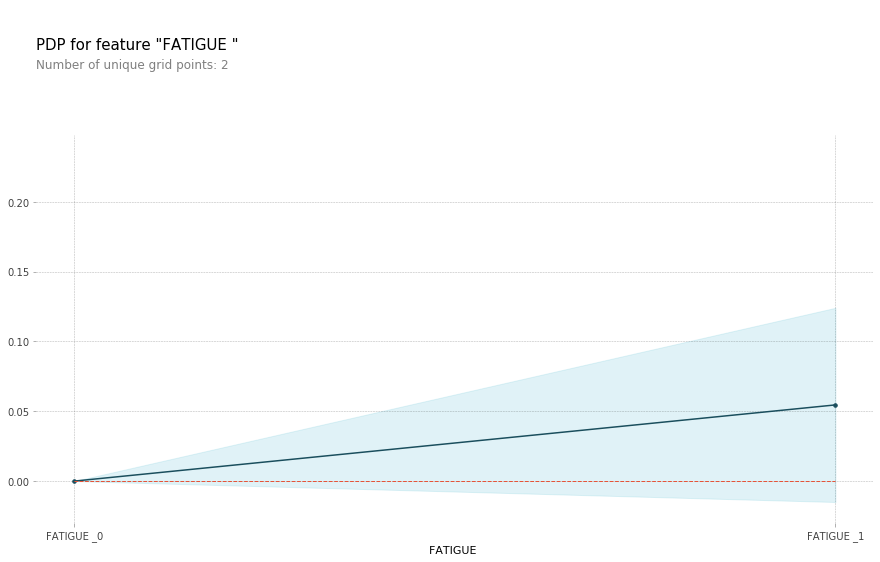

In [ ]:
feature = "FATIGUE "
isolated = pdp_isolate(model=model,=dataset=X_valid, model_features=X_valid.columns, feature=feature, grid_type='percentile', num_grid_points=10)
pdp_plot(isolated, feature_name=feature)

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f515ac5a310>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f515ac8a550>})

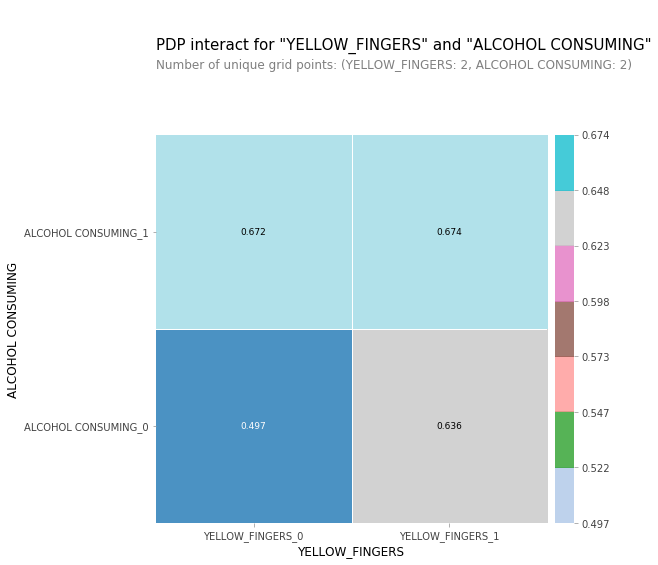

In [ ]:
features = ["YELLOW_FINGERS", "ALCOHOL CONSUMING"]
interaction = pdp_interact(model=model, dataset=X_valid, model_features=X_valid.columns, features=features)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features)